In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.bezier as bezier
from numpy.polynomial.polynomial import Polynomial
import utility

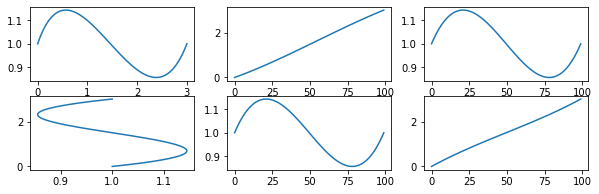

In [2]:
# one_curve = bezier.BezierSegment([[0, 0], [0, 1], [.5, 1.5], [1, 1]])
# other_curve = bezier.BezierSegment([[-0.5, .5], [1, .5], [.5, 1], [2, 2]])
one_curve = bezier.BezierSegment([[0, 1], [.8, 1.5], [2.1, .5], [3, 1]])
other_curve = bezier.BezierSegment([[1, 0], [1.5, 1.2], [.5, 1.8], [1, 3]])

fig, ax = plt.subplots(2,3, figsize=(10, 3))

one_points = np.array(one_curve.point_at_t(np.linspace(0, 1, 100)))
other_points = np.array(other_curve.point_at_t(np.linspace(0, 1, 100)))

ax[0,0].plot(*one_points.T, label='one')
ax[1,0].plot(*other_points.T, label='other')

ax[0,1].plot(one_points.T[0], label='one-x')
ax[1,1].plot(other_points.T[0], label='other-x')

ax[0,2].plot(one_points.T[1], label='one-y')
ax[1,2].plot(other_points.T[1], label='other-y')

In [3]:
def plot_bezier_curve(curve, nTimes=1000):
    x, y = np.array(curve.point_at_t(np.linspace(0,1,1000))).T
    plt.plot(x,y, c='blue')
def plot_bounding_box(box):
    plt.plot([box[0][0], box[0][0], box[0][1], box[0][1], box[0][0]],
             [box[1][0], box[1][1], box[1][1], box[1][0], box[1][0]])
def get_bounding_box_area(box):
    return (box[0][1] - box[0][0]) * (box[1][1] - box[1][0])
def get_bounding_box_intersection(box1, box2):
    x_min, x_max = max(box1[0][0], box2[0][0]), min(box1[0][1], box2[0][1])
    y_min, y_max = max(box1[1][0], box2[1][0]), min(box1[1][1], box2[1][1])
    # if they don't intersect, return -1
    if x_min > x_max or y_min > y_max:
        return -1
    return (x_min, x_max), (y_min, y_max)
def get_bounding_box(curve, min_t=0, max_t=1):
    x_polynomial, y_polynomial = curve.polynomial_coefficients.T # index same as degree
    x_polynomial, y_polynomial = Polynomial(x_polynomial), Polynomial(y_polynomial)
    x_derivative, y_derivative = x_polynomial.deriv(), y_polynomial.deriv()
    (x_begin, y_begin), (x_end, y_end) = curve.point_at_t(min_t), curve.point_at_t(max_t)
    x_min, x_max = min(x_begin, x_end), max(x_begin, x_end)
    y_min, y_max = min(y_begin, y_end), max(y_begin, y_end)

    x_roots, y_roots = x_derivative.roots(), y_derivative.roots()
    x_roots = x_roots[(x_roots >= min_t) & (x_roots <= max_t)]
    y_roots = y_roots[(y_roots >= min_t) & (y_roots <= max_t)]
    # print(x_polynomial, y_polynomial)
    x_at_roots = x_polynomial(x_roots)
    y_at_roots = y_polynomial(y_roots)
    # print(x_at_roots, y_at_roots)
    if len(x_at_roots):
        x_min, x_max = min(x_min, *x_at_roots), max(x_max, *x_at_roots)
    if len(y_at_roots):
        y_min, y_max = min(y_min, *y_at_roots), max(y_max, *y_at_roots)
    return (x_min, x_max), (y_min, y_max)

def intersecting_segment(curve, bounding_box, tmin = 0, tmax=1):
    (x_min, x_max), (y_min, y_max) = bounding_box

    x_polynomial, y_polynomial = curve.polynomial_coefficients.T # index same as degree
    x_polynomial, y_polynomial = Polynomial(x_polynomial), Polynomial(y_polynomial)

    xt_min_roots, xt_max_roots = (x_polynomial-Polynomial([x_min])).roots(), (x_polynomial-Polynomial([x_max])).roots()
    yt_min_roots, yt_max_roots = (y_polynomial-Polynomial([y_min])).roots(), (y_polynomial-Polynomial([y_max])).roots()

    mask = lambda roots: (roots >= tmin) & (roots <= tmax) & np.isreal(roots)
    
    xt_min_roots, xt_max_roots = xt_min_roots[mask(xt_min_roots)], xt_max_roots[mask(xt_max_roots)]
    yt_min_roots, yt_max_roots = yt_min_roots[mask(yt_min_roots)], yt_max_roots[mask(yt_max_roots)]
    print("xt_roots: ", xt_min_roots, xt_max_roots)
    print("yt_roots: ", yt_min_roots, yt_max_roots)
    # plt.scatter([xt_min_roots])
    # get the valid t-values
    t_values = np.real(np.concatenate([xt_min_roots, xt_max_roots, yt_min_roots, yt_max_roots]))
    # print(t_values)
    print (min(t_values), max(t_values))
    plt.scatter(*np.array(curve.point_at_t(min(t_values))))
    plt.scatter(*np.array(curve.point_at_t(max(t_values))))
    return min(t_values), max(t_values)


In [20]:
def get_bezier_intersection(curve1, curve2, min_t1 = 0, max_t1 = 1, min_t2 = 0, max_t2 = 1, tolerance_area = 0.1, plot = False):
    # get the bounding boxes
    box1 = get_bounding_box(curve1, min_t1, max_t1)
    box2 = get_bounding_box(curve2, min_t2, max_t2)
    # get the intersection of the bounding boxes
    intersection_box = get_bounding_box_intersection(box1, box2)
    print("intersection box: ", intersection_box)
    # if they don't intersect, return None
    if intersection_box == -1:
        return None
    # make the intersection box 5% smaller
    # (x_min, x_max), (y_min, y_max) = intersection_box
    # x_trim = (x_max - x_min) * .05
    # y_trim = (y_max - y_min) * .05
    # x_min, x_max = x_min + x_trim, x_max - x_trim
    # y_min, y_max = y_min + y_trim, y_max - y_trim
    print(get_bounding_box_area(intersection_box))
    if plot:
        plot_bezier_curve(curve1)
        plot_bezier_curve(curve2)
        plot_bounding_box(intersection_box)
        plt.show()
        input()
    print(get_bounding_box_area(intersection_box))
    if get_bounding_box_area(intersection_box) < tolerance_area:
        return intersection_box
    else:
        # get the t-values of the intersection of the bounding boxes
        min_t1, max_t1 = intersecting_segment(curve1, intersection_box, min_t1, max_t1)
        min_t2, max_t2 = intersecting_segment(curve2, intersection_box, min_t2, max_t2)
        # mask tmin, tmax
        min_t1, max_t1 = max(0, min_t1), min(1, max_t1)
        min_t1, max_t1 = max(0, min_t2), min(1, max_t2)

        print("subcurve1: ", [min_t1, max_t1])
        print("subcurve2: ", [min_t2, max_t2])
        if plot:
            plt.scatter(*np.array(curve1.point_at_t([min_t1, max_t1])).T)
            plt.scatter(*np.array(curve2.point_at_t([min_t2, max_t2])).T)

        # get the bounding boxes of the intersection of the bounding boxes
        return get_bezier_intersection(curve1, curve2, *[min_t1, max_t1], *[min_t2, max_t2], plot = True)

xt_roots:  [0.30815083] [0.40061156]
yt_roots:  [] []
0.30815082735664784 0.4006115563203223
xt_roots:  [] []
yt_roots:  [0.26697984+0.j] [0.36926624+0.j]
0.2669798432885727 0.3692662449620439


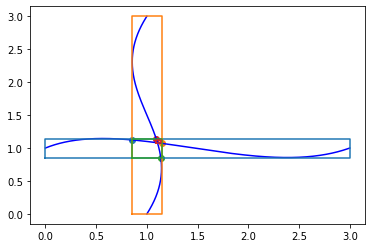

In [21]:

one_curve = bezier.BezierSegment([[0, 1], [.8, 1.5], [2.1, .5], [3, 1]])
other_curve = bezier.BezierSegment([[1, 0], [1.5, 1.2], [.5, 1.8], [1, 3]])


# now we can use this function to get the bounding boxes of each curve
one_box = get_bounding_box(one_curve)
other_box = get_bounding_box(other_curve)

# plot the first curve and bounding box
plot_bezier_curve(one_curve)
plot_bounding_box(one_box)

# plot the other curve and bounding box
plot_bezier_curve(other_curve)
plot_bounding_box(other_box)

# get the intersection bounding box
(x_min, x_max), (y_min, y_max) = get_bounding_box_intersection(one_box, other_box)

intersecting_box = (x_min, x_max), (y_min, y_max)

# plot the intersection of the bounding boxes
plot_bounding_box(intersecting_box)

tmin, tmax = intersecting_segment(one_curve, intersecting_box)
one_sub1_box = get_bounding_box(one_curve, tmin, tmax)

tmin, tmax = intersecting_segment(other_curve, intersecting_box)
other_sub1_box = get_bounding_box(other_curve, tmin, tmax)

# plot_bounding_box(one_sub1_box)
# plot_bounding_box(other_sub1_box)

sub_intersection1 = get_bounding_box_intersection(one_sub1_box, other_sub1_box)
plot_bounding_box(sub_intersection1)


In [22]:
get_bezier_intersection(one_curve, other_curve)

intersection box:  ((0.8556624327025935, 1.1443375672974065), (0.8556624327025935, 1.1443375672974065))
0.08333333333333345
0.08333333333333345


((0.8556624327025935, 1.1443375672974065),
 (0.8556624327025935, 1.1443375672974065))

xt_roots:  [0.30815083] [0.40061156]
yt_roots:  [] []
0.30815082735664784 0.4006115563203223
xt_roots:  [] []
yt_roots:  [0.26697984+0.j] [0.36926624+0.j]
0.2669798432885727 0.3692662449620439


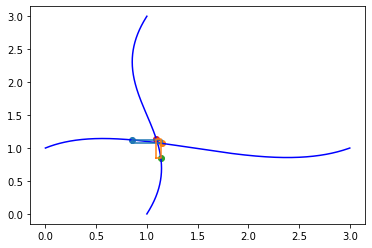

In [9]:


sub_one = intersecting_segment(one_curve, intersecting_box)
sub_other = intersecting_segment(other_curve, intersecting_box)

small_bounding_box_one = get_bounding_box(one_curve, min_t=min(sub_one), max_t=max(sub_one))
small_bounding_box_other = get_bounding_box(other_curve, min_t=min(sub_other), max_t=max(sub_other))

plot_bezier_curve(one_curve)
plot_bezier_curve(other_curve)
plot_bounding_box(small_bounding_box_one)
plot_bounding_box(small_bounding_box_other)


intersection box:  ((0.8556624327025935, 1.1443375672974065), (0.8556624327025935, 1.1443375672974065))
0.08333333333333345


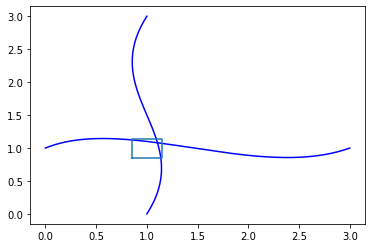

0.08333333333333345
xt_roots:  [0.30815083] [0.40061156]
yt_roots:  [] []
0.30815082735664784 0.4006115563203223
xt_roots:  [] []
yt_roots:  [0.26697984+0.j] [0.36926624+0.j]
0.2669798432885727 0.3692662449620439
intersection box:  ((1.0913470810281873, 1.1368072570921892), (1.0715960369137358, 1.1227032170798024))
0.0023233414084840487


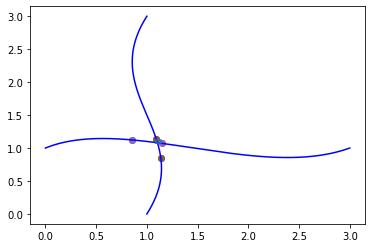

0.0023233414084840487


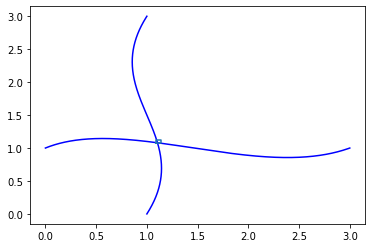

In [16]:
intersection = get_bezier_intersection(one_curve, other_curve, tolerance_area = 0.00000001, plot=True)
plot_bezier_curve(one_curve)
plot_bezier_curve(other_curve)
plot_bounding_box(intersection)

intersection box:  ((1.0, 2.5), (0.5, 4.0))
5.25


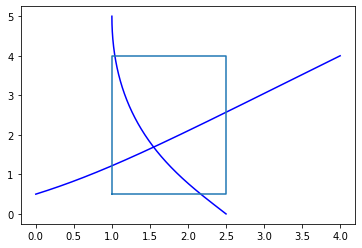

5.25
xt_roots:  [0.32874496+0.j] [0.72224086+0.j]
yt_roots:  [0.+0.j] [1.+0.j]
0.0 0.9999999999999998
xt_roots:  [0. 0.] [1.]
yt_roots:  [0.82740967+0.j] [0.1235932+0.j]
0.0 1.0
intersection box:  ((1.0, 2.5), (0.5, 3.9999999999999987))
5.249999999999998


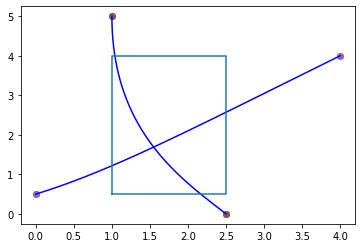

5.249999999999998
xt_roots:  [0.32874496+0.j] [0.72224086+0.j]
yt_roots:  [0.+0.j] [1.+0.j]
0.0 0.9999999999999998
xt_roots:  [0. 0.] [1.]
yt_roots:  [0.82740967+0.j] [0.1235932+0.j]
0.0 1.0
intersection box:  ((1.0, 2.5), (0.5, 3.9999999999999987))
5.249999999999998


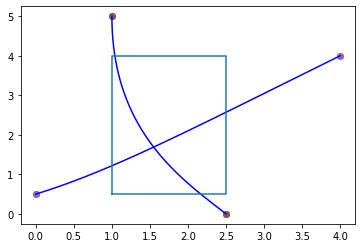

5.249999999999998
xt_roots:  [0.32874496+0.j] [0.72224086+0.j]
yt_roots:  [0.+0.j] [1.+0.j]
0.0 0.9999999999999998
xt_roots:  [0. 0.] [1.]
yt_roots:  [0.82740967+0.j] [0.1235932+0.j]
0.0 1.0
intersection box:  ((1.0, 2.5), (0.5, 3.9999999999999987))
5.249999999999998


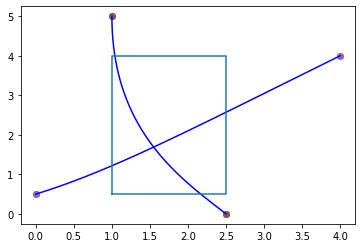

5.249999999999998
xt_roots:  [0.32874496+0.j] [0.72224086+0.j]
yt_roots:  [0.+0.j] [1.+0.j]
0.0 0.9999999999999998
xt_roots:  [0. 0.] [1.]
yt_roots:  [0.82740967+0.j] [0.1235932+0.j]
0.0 1.0
intersection box:  ((1.0, 2.5), (0.5, 3.9999999999999987))
5.249999999999998


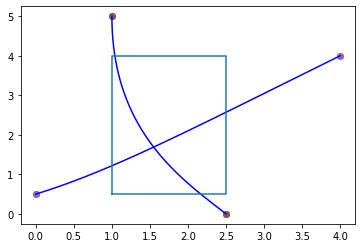

In [17]:
one_curve = bezier.BezierSegment([[0,.5],[1,1.1],[1.9,2],[4,4]])
other_curve = bezier.BezierSegment([[1,5],[1,2.1],[1.9,0.9],[2.5,0]])

intersection = get_bezier_intersection(one_curve, other_curve, tolerance_area = 1, plot = True)
plot_bezier_curve(one_curve)
plot_bezier_curve(other_curve)
plot_bounding_box(intersection)